In [33]:
import math
import os
from glob import glob
from itertools import combinations
from urllib.error import URLError

import earthpy as et
import earthpy.appeears as etapp
import geopandas as gpd
import holoviews as hv
import hvplot as hv
import hvplot.pandas
import hvplot.xarray
from IPython.display import display
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np
from osgeo import gdal
import pandas as pd
from PIL import Image
import requests
import rasterio
from rasterio.merge import merge
from rasterio.plot import show
from shapely.geometry import box, Point
import skfuzzy as fuzz
from skfuzzy import control as ctrl
from IPython.display import display
import utm
import xarray as xr
import xrspatial
import warnings
import zipfile


gdal.UseExceptions()

In [2]:
# Define directories and filepaths
external_data_dir = '/Volumes/T9/lafayette_clustering'

# Data Set #1: Denver Regional Aerial Imagery Boundary
drapp_url = (
    'https://gisdata.drcog.org:8443'
    '/geoserver/DRCOGPUB/ows?'
    'service=WFS&version=1.0.0&'
    'request=GetFeature&'
    'typeName=DRCOGPUB:drapp_tile_scheme_2020'
    '&outputFormat=SHAPE-ZIP'
)
drapp_shp_file = os.path.join(external_data_dir, 'drapp_tile_scheme_2020', 'drapp_tile_scheme_2020.shp')
drapp_dir = os.path.join(external_data_dir, 'drapp_tile_scheme_2020')

# Data Set #2: Denver Regional Aerial Imagery Tiles
external_data_dir = '/Volumes/T9/lafayette_clustering'
drapp_tiles_dir = os.path.join(external_data_dir, 'drapp_tiles')
os.makedirs(drapp_tiles_dir, exist_ok=True)

In [3]:
# study site

# Define the location point
latitude = 39.986982
longitude = -105.098750
location_point = Point(longitude, latitude)

# Define the bounding box
buffer = 0.005
bbox = box(location_point.x - buffer, location_point.y - buffer, location_point.x + buffer, location_point.y + buffer)

# Create a GeoDataFrame with the bounding box
study_site = gpd.GeoDataFrame(geometry=[bbox], crs="EPSG:4326")
study_site.hvplot(geo=True, tiles="OSM", alpha=0.5)

:Overlay
   .WMTS.I     :WMTS   [Longitude,Latitude]
   .Polygons.I :Polygons   [Longitude,Latitude]

In [4]:
def extract_zip(target_dir, zip_filename, resp):
    zip_path = os.path.join(data_dir, zip_filename)
    with open(zip_path, 'wb') as f:
        f.write(resp.content)
    with zipfile.ZipFile(zip_path, 'r') as z:
        z.extractall(target_dir)

In [5]:
if not os.path.exists(drapp_shp_file):
    resp = requests.get(drapp_url)
    extract_zip(drapp_dir, 'drapp_tile_scheme_2020.zip', resp)
else:
    print('File already exists')

File already exists


In [6]:
drapp_gdf = gpd.read_file(drapp_shp_file)
drapp_gdf = drapp_gdf.to_crs(study_site.crs) # EPSG:6428 -> EPSG:4326
lafayette_drapp = gpd.sjoin(drapp_gdf, study_site, how='inner', predicate='intersects')

In [7]:
lafayette_drapp_plot = lafayette_drapp.hvplot(geo=True, color='red', tiles='OSM', 
                    alpha=0.3, hover_cols=['tile'])
lafayette_drapp_plot

:Overlay
   .WMTS.I     :WMTS   [Longitude,Latitude]
   .Polygons.I :Polygons   [Longitude,Latitude]   (tile)

In [8]:
lafayette_drapp

project area      resolution     tile photo_date       storage  \
4765     2020   1a  3 Inch, 6 Inch  N2W134a   20200410  drapparchive   
4766     2020   1a  3 Inch, 6 Inch  N2W134b   20200421  drapparchive   
4827     2020   1a  3 Inch, 6 Inch  N2W124c   20200410  drapparchive   
4828     2020   1a  3 Inch, 6 Inch  N2W124d   20200421  drapparchive   

                                               geometry  index_right  
4765  POLYGON ((-105.10853 39.98017, -105.10849 39.9...            0  
4766  POLYGON ((-105.09911 39.98014, -105.09907 39.9...            0  
4827  POLYGON ((-105.10849 39.98742, -105.10845 39.9...            0  
4828  POLYGON ((-105.09907 39.98739, -105.09903 39.9...            0

In [10]:
if len(lafayette_drapp['tile']) != len(lafayette_drapp['tile'].unique()):
    raise ValueError('There are duplicate tiles in the dataset')

In [11]:
tile_base_url = 'https://drapparchive.s3.amazonaws.com/2020/'
tile_urls = [f'{tile_base_url}{tile}.tif' for tile in lafayette_drapp['tile']]

In [12]:
lafayette_drapp

project area      resolution     tile photo_date       storage  \
4765     2020   1a  3 Inch, 6 Inch  N2W134a   20200410  drapparchive   
4766     2020   1a  3 Inch, 6 Inch  N2W134b   20200421  drapparchive   
4827     2020   1a  3 Inch, 6 Inch  N2W124c   20200410  drapparchive   
4828     2020   1a  3 Inch, 6 Inch  N2W124d   20200421  drapparchive   

                                               geometry  index_right  
4765  POLYGON ((-105.10853 39.98017, -105.10849 39.9...            0  
4766  POLYGON ((-105.09911 39.98014, -105.09907 39.9...            0  
4827  POLYGON ((-105.10849 39.98742, -105.10845 39.9...            0  
4828  POLYGON ((-105.09907 39.98739, -105.09903 39.9...            0

In [13]:
merged_gdf = lafayette_drapp.dissolve()
merged_gdf

geometry  project area  \
0  POLYGON ((-105.08969 39.98011, -105.09911 39.9...     2020   1a   

       resolution     tile photo_date       storage  index_right  
0  3 Inch, 6 Inch  N2W134a   20200410  drapparchive            0

In [14]:
merged_gdf.bounds

minx       miny        maxx       maxy
0 -105.108532  39.980107 -105.089608  39.994664

In [15]:
from geopy.distance import geodesic

# Sample bounding box coordinates
min_lon, min_lat, max_lon, max_lat = merged_gdf.bounds.astype(float).values[0]

# Calculate distances
width_miles = geodesic((min_lat, min_lon), (min_lat, max_lon)).miles
height_miles = geodesic((min_lat, min_lon), (max_lat, min_lon)).miles

print("Width of bounding box:", width_miles, "miles")
print("Height of bounding box:", height_miles, "miles")

Width of bounding box: 1.004456258639464 miles
Height of bounding box: 1.0043496588259755 miles


In [16]:
def download_files(urls):
    paths = []
    for url in urls:
        print(f"Downloading {url}...")
        filename = os.path.basename(url)
        path = os.path.join(drapp_tiles_dir, filename)
        paths.append(path)
        if not os.path.exists(path):
            resp = requests.get(url)
            with open(path, 'wb') as f:
                f.write(resp.content)
    return paths

In [17]:
tile_paths = download_files(tile_urls)

In [18]:
tile_paths

['/Volumes/T9/lafayette_clustering/drapp_tiles/N2W134a.tif',
 '/Volumes/T9/lafayette_clustering/drapp_tiles/N2W134b.tif',
 '/Volumes/T9/lafayette_clustering/drapp_tiles/N2W124c.tif',
 '/Volumes/T9/lafayette_clustering/drapp_tiles/N2W124d.tif']

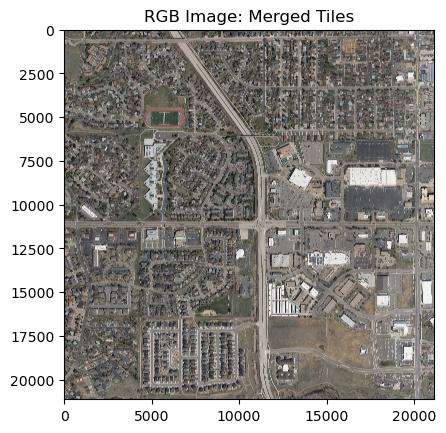

In [44]:
# Open all the files
src_files_to_mosaic = [rasterio.open(path) for path in tile_paths]
mosaic, out_trans = merge(src_files_to_mosaic)
red = mosaic[0]
green = mosaic[1]
blue = mosaic[2]
nir = mosaic[3]
rgb = np.dstack((red, green, blue))
plt.imshow(rgb)
plt.title('RGB Image: Merged Tiles')
plt.savefig('../img/pre_cluster_rgb_image.png')
plt.show()

In [20]:
with rasterio.open(test_tile_path) as src:
    # Assuming that there are 4 bands: R, G, B, and NIR
    # For INTERLEAVE=PIXEL, read directly to a shape (height, width, bands)
    img = src.read()  # Read all bands

In [29]:
# Process each TIFF file
plot_files = []
for file_idx, file_path in enumerate(tile_paths):
    tile_name = file_path.split('/')[-1].split('.')[0]
    plot_filename = f'../img/cluster_plot_{tile_name}.png'
    if os.path.exists(plot_filename):
        print(f"Skipping {file_path}")
        plot_files.append(plot_filename)
        continue
    else:
        print(f"Processing {file_path}")
        dataset = gdal.Open(file_path)
        band_data = []

        geo_transform = dataset.GetGeoTransform()
        x_coords = np.zeros((dataset.RasterYSize, dataset.RasterXSize))
        y_coords = np.zeros((dataset.RasterYSize, dataset.RasterXSize))

        for y in range(dataset.RasterYSize):
            for x in range(dataset.RasterXSize):
                x_coords[y, x] = geo_transform[0] + x * geo_transform[1] + y * geo_transform[2]
                y_coords[y, x] = geo_transform[3] + x * geo_transform[4] + y * geo_transform[5]

        # Read band 1-4
        for i in range(1, dataset.RasterCount + 1):
            band = dataset.GetRasterBand(i)
            band_data.append(band.ReadAsArray())

        # Stack bands
        image_data = np.dstack(band_data)

        flattened_data = image_data.reshape((dataset.RasterYSize * dataset.RasterXSize, -1))
        x_coords_flattened = x_coords.flatten()
        y_coords_flattened = y_coords.flatten()
        df = pd.DataFrame(flattened_data, columns=[f'band_{i}' for i in range(1, dataset.RasterCount + 1)])
        df.index = pd.MultiIndex.from_arrays([x_coords_flattened, y_coords_flattened], names=['X', 'Y'])

        # K-means clustering
        k = 5
        kmeans = KMeans(n_clusters=k, random_state=0, n_init=10)
        df['cluster'] = kmeans.fit_predict(df[[f'band_{i}' for i in range(1, dataset.RasterCount + 1)]])
        cluster_labels = df['cluster'].values.reshape(dataset.RasterYSize, dataset.RasterXSize)

        # Save the plot
        fig, ax = plt.subplots(figsize=(10, 10))
        cax = ax.imshow(cluster_labels, cmap='viridis')
        plt.colorbar(cax)
        ax.set_title(f'Clustering {tile_name} with K-means (k={k})')
        ax.set_xlabel('Pixel X Position')
        ax.set_ylabel('Pixel Y Position')
        plt.savefig(plot_filename)
        plt.close()
        plot_files.append(plot_filename)

Processing /Volumes/T9/lafayette_clustering/drapp_tiles/N2W134a.tif
Processing /Volumes/T9/lafayette_clustering/drapp_tiles/N2W134b.tif
Processing /Volumes/T9/lafayette_clustering/drapp_tiles/N2W124c.tif
Processing /Volumes/T9/lafayette_clustering/drapp_tiles/N2W124d.tif


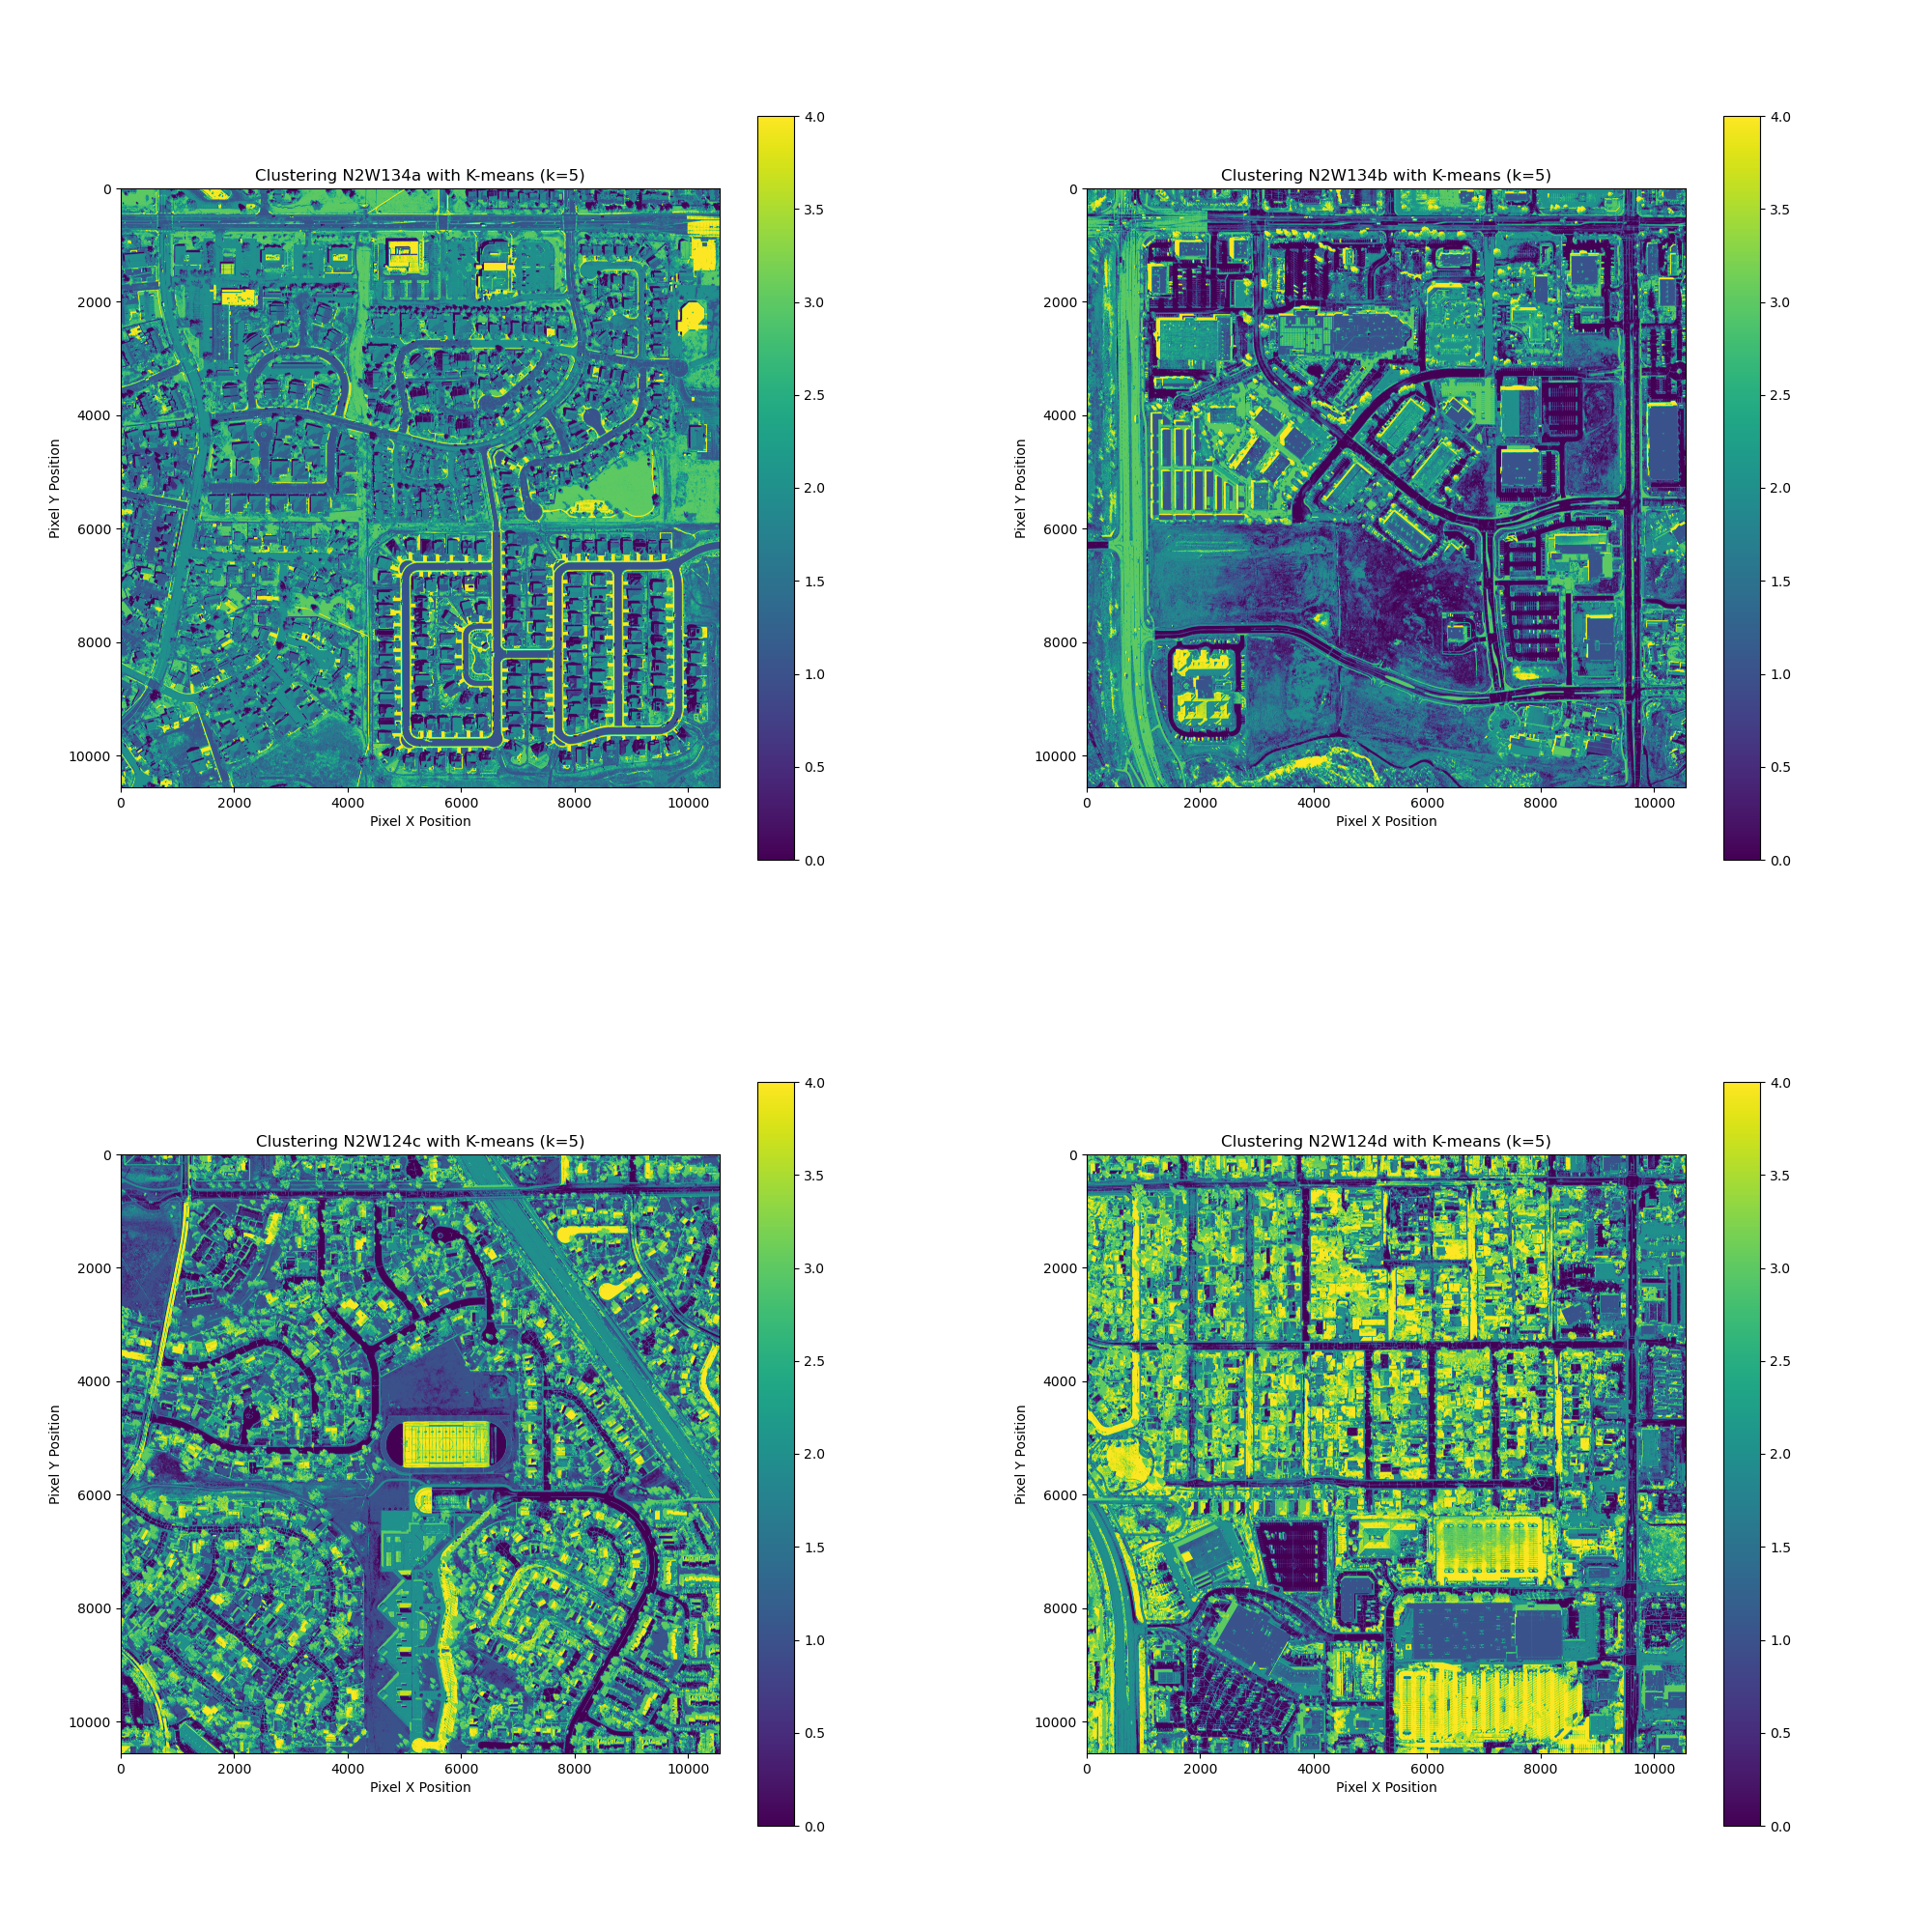

In [36]:
images = [Image.open(x) for x in plot_files]
widths, heights = zip(*(i.size for i in images))
max_width_per_col = max(widths[0:2]), max(widths[2:4])
max_height_per_row = max(heights[0], heights[1]), max(heights[2], heights[3])

total_width = sum(max_width_per_col)
total_height = sum(max_height_per_row)

new_im = Image.new('RGB', (total_width, total_height))
positions = [
    (0, 0),  # Top-left
    (max_width_per_col[0], 0),  # Top-right
    (0, max_height_per_row[0]),  # Bottom-left
    (max_width_per_col[0], max_height_per_row[0])  # Bottom-right
]
for img, pos in zip(images, positions):
    new_im.paste(img, pos)
composite_image_path = '../img/composite_cluster_plot.png'
new_im.save(composite_image_path)
display(new_im)

In [45]:
%%capture
%%bash
jupyter nbconvert lafayette_clustering.ipynb --to html --no-input